In [2]:
from neo4j import GraphDatabase

NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "Deadagain"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def test_connection(tx):
    result = tx.run("MATCH (n) RETURN count(n) AS count")
    for record in result:
        print(f"Connected! Total nodes in DB: {record['count']}")

with driver.session() as session:
    session.execute_read(test_connection)


Connected! Total nodes in DB: 11560


In [4]:
import pandas as pd

query = """
MATCH (o:Bank)-[:SENT]->(t:Transaction)-[:RECEIVED]->(b:Bank)
RETURN o.id AS originator, b.id AS beneficiary, t.amount_transactions AS amount, t.suspicious_flag AS fraud_label
"""

def fetch_transactions():
    with driver.session() as session:
        result = session.run(query)
        data = pd.DataFrame([dict(record) for record in result])
    return data

transactions_df = fetch_transactions()
print(transactions_df.head())


                originator         beneficiary      amount  fraud_label
0  caledonian-bank-limited  hsbc-hong-kong-hkg   417000.00         True
1  caledonian-bank-limited  hsbc-hong-kong-hkg  1990000.00         True
2       trasta-komercbanka  hsbc-hong-kong-hkg   252122.34         True
3        aizkraukles-banka  hsbc-hong-kong-hkg  1034850.00         True
4            as-privatbank  hsbc-hong-kong-hkg  2124000.00         True


In [20]:
import torch
from torch_geometric.data import Data

# Create a unified mapping for all unique bank names
all_banks = pd.concat([transactions_df['originator'], transactions_df['beneficiary']]).unique()
bank_mapping = {name: idx for idx, name in enumerate(all_banks)}

# Apply the mapping to both columns
transactions_df['originator'] = transactions_df['originator'].map(bank_mapping)
transactions_df['beneficiary'] = transactions_df['beneficiary'].map(bank_mapping)

# Convert to PyTorch tensors
import numpy as np

# Convert to NumPy array first to avoid performance warning
edge_index_np = np.array([transactions_df['originator'].values, transactions_df['beneficiary'].values])

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_index_np, dtype=torch.long)

edge_attr = torch.tensor(transactions_df['amount'].values, dtype=torch.float).view(-1, 1)
y = torch.tensor(transactions_df['fraud_label'].astype(int).values, dtype=torch.long)

# Create PyTorch Geometric Data object
graph_data = Data(edge_index=edge_index, edge_attr=edge_attr, y=y)

print(graph_data)


Data(edge_index=[2, 9014], edge_attr=[9014, 1], y=[9014])


In [22]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class FraudDetectorGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudDetectorGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.edge_attr, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x.view(-1)

model = FraudDetectorGNN(input_dim=1, hidden_dim=16)
print(model)


FraudDetectorGNN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 1)
)


In [24]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(graph_data, model, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out, graph_data.y.float())
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train_model(graph_data, model)

Epoch 0, Loss: 1471021.875
Epoch 10, Loss: 39124.51953125
Epoch 20, Loss: 63813.58203125
Epoch 30, Loss: 68919.890625
Epoch 40, Loss: 66259.8671875


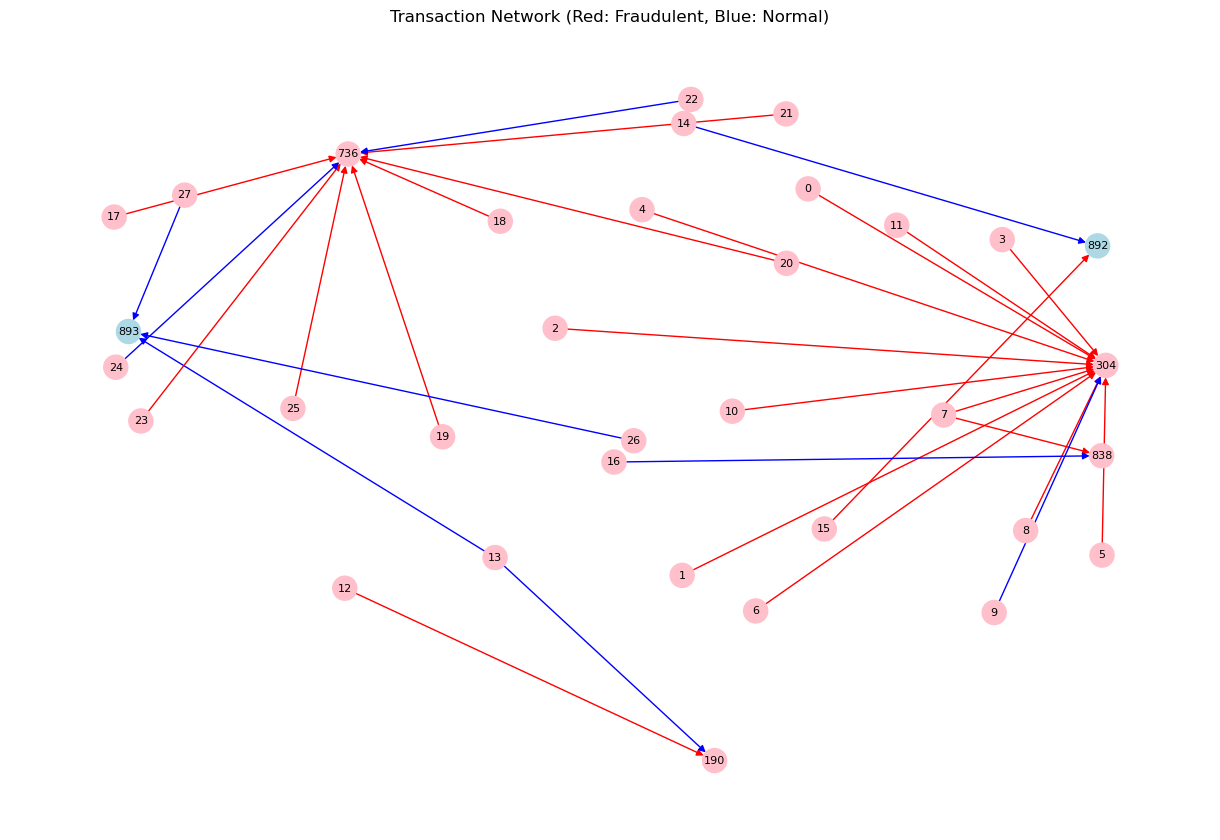

C:\Users\zahwa\transaction network.png

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_network(graph_data, num_nodes=100):
    G = nx.DiGraph()  # Directed Graph

    # Get a subset of edges to prevent overcrowding
    subset_edges = graph_data.edge_index[:, :min(num_nodes, graph_data.edge_index.shape[1])].T.tolist()
    labels = graph_data.y[:min(num_nodes, len(graph_data.y))].tolist()

    for (src, dst), label in zip(subset_edges, labels):
        color = "red" if label == 1 else "blue"  # Red for fraud, Blue for normal
        G.add_edge(src, dst, color=color)

    # Extract edge colors
    edge_colors = [G[u][v]['color'] for u, v in G.edges]

    # Assign node colors
    node_colors = ["pink" if node in graph_data.edge_index[0].tolist() else "lightblue" for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.8)  # Improve spacing
    nx.draw(G, pos, edge_color=edge_colors, node_color=node_colors, node_size=300, with_labels=True, arrows=True, font_size=8)
    
    # Add title
    plt.title("Transaction Network (Red: Fraudulent, Blue: Normal)")
    plt.show()

# Call the visualization function
visualize_transaction_network(graph_data)



Graph saved as transaction_network.png


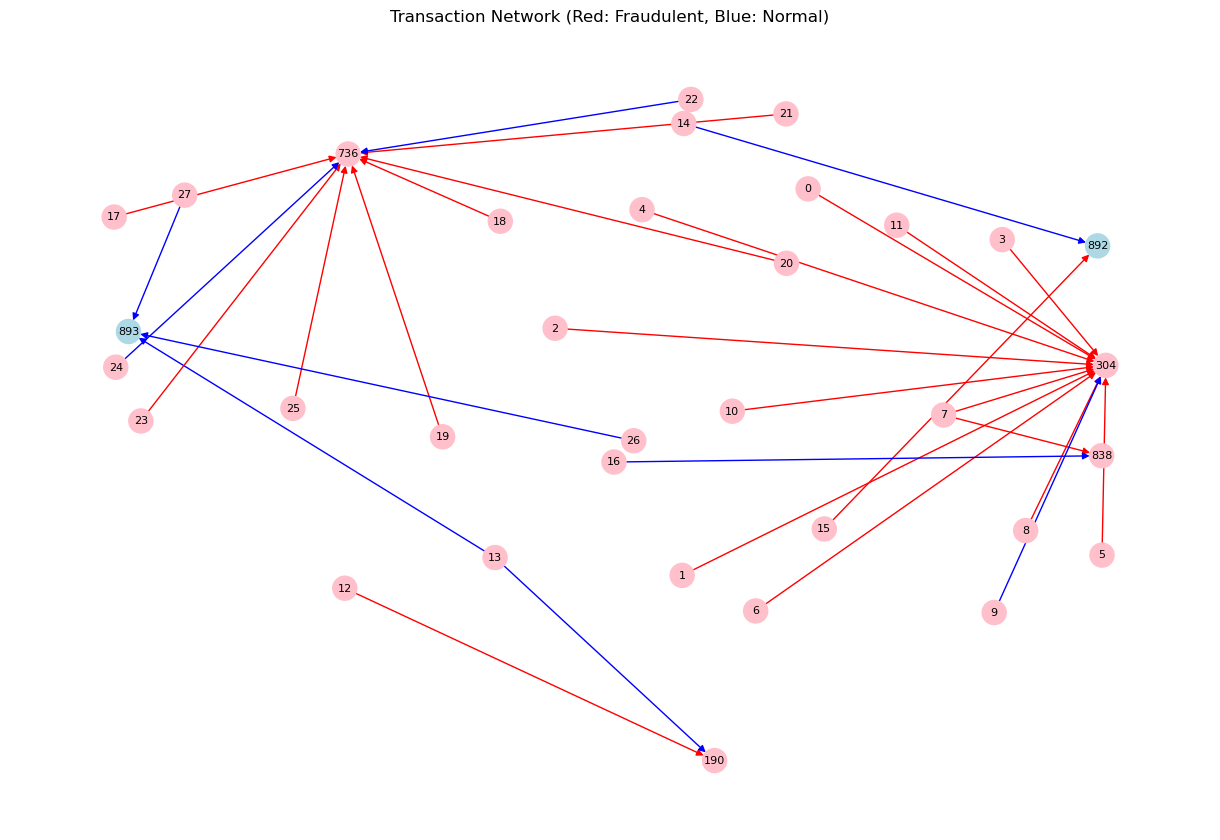

C:\Users\zahwa\transaction_network.png

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_network(graph_data, num_nodes=100, save_path="transaction_network.png"):
    G = nx.DiGraph()  # Directed Graph

    # Get a subset of edges to prevent overcrowding
    subset_edges = graph_data.edge_index[:, :min(num_nodes, graph_data.edge_index.shape[1])].T.tolist()
    labels = graph_data.y[:min(num_nodes, len(graph_data.y))].tolist()

    for (src, dst), label in zip(subset_edges, labels):
        color = "red" if label == 1 else "blue"  # Red for fraud, Blue for normal
        G.add_edge(src, dst, color=color)

    # Extract edge colors
    edge_colors = [G[u][v]['color'] for u, v in G.edges]

    # Assign node colors
    node_colors = ["pink" if node in graph_data.edge_index[0].tolist() else "lightblue" for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.8)  # Improve spacing
    nx.draw(G, pos, edge_color=edge_colors, node_color=node_colors, node_size=300, with_labels=True, arrows=True, font_size=8)
    
    # Add title
    plt.title("Transaction Network (Red: Fraudulent, Blue: Normal)")
    
    # Save the image before displaying it
    plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")
    print(f"Graph saved as {save_path}")
    
    # Show the plot
    plt.show()

# Call the function with a save path
visualize_transaction_network(graph_data, save_path="transaction_network.png")
from IPython.display import FileLink
FileLink("transaction_network.png")
